In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle

Exploring The Data

In [266]:
df = pd.read_csv('glassdoor_jobs.csv')
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         956 non-null    int64  
 1   Job Title          956 non-null    object 
 2   Salary Estimate    956 non-null    object 
 3   Job Description    956 non-null    object 
 4   Rating             956 non-null    float64
 5   Company Name       956 non-null    object 
 6   Location           956 non-null    object 
 7   Headquarters       956 non-null    object 
 8   Size               956 non-null    object 
 9   Founded            956 non-null    int64  
 10  Type of ownership  956 non-null    object 
 11  Industry           956 non-null    object 
 12  Sector             956 non-null    object 
 13  Revenue            956 non-null    object 
 14  Competitors        956 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 112.2+ KB


Cleaning The Data

In [268]:
#Remove rows with no salary estimate
df = df[df['Salary Estimate'] != '-1']

In [269]:
df

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),"Pfizer, AstraZeneca, Merck"
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini"
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1


In [270]:
#Is salary per hour?
df['hourly'] = df['Salary Estimate'].apply(lambda x : 1 if 'per hour' in x.lower() else 0)
df['employer_provided'] = df['Salary Estimate'].apply(lambda x : 1 if 'employer provided salary:' in x.lower() else 0)
df

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,hourly,employer_provided
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),"Pfizer, AstraZeneca, Merck",0,0
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",0,0
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1,0,0
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1,0,0


In [271]:
#cleaning Salary Estimate column
salary = df['Salary Estimate'].apply(lambda x : x.split('(')[0])
salary

0       $53K-$91K 
1      $63K-$112K 
2       $80K-$90K 
3       $56K-$97K 
4      $86K-$143K 
          ...     
950    $58K-$111K 
951    $72K-$133K 
952     $56K-$91K 
953    $95K-$160K 
955    $61K-$126K 
Name: Salary Estimate, Length: 742, dtype: object

In [272]:
minus_kd = salary.apply(lambda x : x.replace('K' , '').replace('$', ''))
minus_kd

0       53-91 
1      63-112 
2       80-90 
3       56-97 
4      86-143 
        ...   
950    58-111 
951    72-133 
952     56-91 
953    95-160 
955    61-126 
Name: Salary Estimate, Length: 742, dtype: object

In [273]:
min_hr = minus_kd.apply(lambda x : x.lower().replace('per hour', '').replace('employer provided salary:', ''))
min_hr

0       53-91 
1      63-112 
2       80-90 
3       56-97 
4      86-143 
        ...   
950    58-111 
951    72-133 
952     56-91 
953    95-160 
955    61-126 
Name: Salary Estimate, Length: 742, dtype: object

In [274]:
#Get the min, max and average salary
df['min_salary'] = min_hr.apply(lambda x : int(x.split('-')[0]))
df['max_salary'] = min_hr.apply(lambda x : int(x.split('-')[1]))
df['average_salary'] = (df['max_salary'] + df['min_salary']) / 2
df

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,average_salary
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),"Pfizer, AstraZeneca, Merck",0,0,58,111,84.5
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",0,0,72,133,102.5
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1,0,0,56,91,73.5
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1,0,0,95,160,127.5


In [275]:
#Removing raring from Company Name
df['company_txt'] = df.apply(lambda x : x['Company Name'][:-3] if x['Rating'] > 0 else x['Company Name'], axis=1)
df


,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,Industry,Sector,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,average_salary,company_txt
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0,Tecolote Research\n
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5,University of Maryland Medical System\n
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0,KnowBe4\n
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5,PNNL\n
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5,Affinity Solutions\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,...,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),"Pfizer, AstraZeneca, Merck",0,0,58,111,84.5,GSK\n
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,...,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",0,0,72,133,102.5,Eventbrite\n
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,...,Colleges & Universities,Education,Unknown / Non-Applicable,-1,0,0,56,91,73.5,Software Engineering Institute\n
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,...,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1,0,0,95,160,127.5,"Numeric, LLC\n"


In [276]:
#Get the state
df['job_state'] = df.apply(lambda x : x['Location'].split(', ')[1], axis=1)
df

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,Sector,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,average_salary,company_txt,job_state
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0,Tecolote Research\n,NM
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5,University of Maryland Medical System\n,MD
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0,KnowBe4\n,FL
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5,PNNL\n,WA
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5,Affinity Solutions\n,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,...,Biotech & Pharmaceuticals,$10+ billion (USD),"Pfizer, AstraZeneca, Merck",0,0,58,111,84.5,GSK\n,MA
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,...,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",0,0,72,133,102.5,Eventbrite\n,TN
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,...,Education,Unknown / Non-Applicable,-1,0,0,56,91,73.5,Software Engineering Institute\n,PA
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,...,Business Services,$5 to $10 million (USD),-1,0,0,95,160,127.5,"Numeric, LLC\n",PA


In [277]:
df['job_state'].value_counts()

job_state
CA             151
MA             103
NY              72
VA              41
IL              40
MD              35
PA              33
TX              28
WA              21
NC              21
NJ              17
FL              16
OH              14
TN              13
DC              11
CO              11
WI              10
IN              10
UT              10
AZ               9
MO               9
AL               8
GA               6
KY               6
DE               6
MI               6
CT               5
IA               5
LA               4
OR               4
NE               4
NM               3
KS               3
ID               2
MN               2
Los Angeles      1
RI               1
SC               1
Name: count, dtype: int64

In [278]:
#Are the job locations and the headquarters the same?
df['same_state'] = df.apply(lambda x : 1 if x['Location'] == x['Headquarters'] else 0, axis=1)
df

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,average_salary,company_txt,job_state,same_state
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,$50 to $100 million (USD),-1,0,0,53,91,72.0,Tecolote Research\n,NM,0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,$2 to $5 billion (USD),-1,0,0,63,112,87.5,University of Maryland Medical System\n,MD,0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,$100 to $500 million (USD),-1,0,0,80,90,85.0,KnowBe4\n,FL,1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5,PNNL\n,WA,1
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5,Affinity Solutions\n,NY,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,...,$10+ billion (USD),"Pfizer, AstraZeneca, Merck",0,0,58,111,84.5,GSK\n,MA,0
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,...,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",0,0,72,133,102.5,Eventbrite\n,TN,0
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,...,Unknown / Non-Applicable,-1,0,0,56,91,73.5,Software Engineering Institute\n,PA,1
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,...,$5 to $10 million (USD),-1,0,0,95,160,127.5,"Numeric, LLC\n",PA,0


In [279]:
#Age of the company
df['age'] = df['Founded'].apply(lambda x : x if x < 1 else 2023 - x)
df

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,Competitors,hourly,employer_provided,min_salary,max_salary,average_salary,company_txt,job_state,same_state,age
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,-1,0,0,53,91,72.0,Tecolote Research\n,NM,0,50
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,-1,0,0,63,112,87.5,University of Maryland Medical System\n,MD,0,39
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,-1,0,0,80,90,85.0,KnowBe4\n,FL,1,13
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,"Oak Ridge National Laboratory, National Renewa...",0,0,56,97,76.5,PNNL\n,WA,1,58
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5,Affinity Solutions\n,NY,1,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,...,"Pfizer, AstraZeneca, Merck",0,0,58,111,84.5,GSK\n,MA,0,193
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,...,"See Tickets, TicketWeb, Vendini",0,0,72,133,102.5,Eventbrite\n,TN,0,17
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,...,-1,0,0,56,91,73.5,Software Engineering Institute\n,PA,1,39
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,...,-1,0,0,95,160,127.5,"Numeric, LLC\n",PA,0,-1


Job requirements Python, R, Spark, AWS, Excel 

In [280]:
df['python_yn'] = df['Job Description'].apply(lambda x : 1 if 'python' in x.lower() else 0)
df['python_yn'].value_counts()

python_yn
1    392
0    350
Name: count, dtype: int64

In [281]:
df['R_yn'] = df['Job Description'].apply(lambda x : 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df['R_yn'].value_counts()

R_yn
0    740
1      2
Name: count, dtype: int64

In [282]:
df['spark_yn'] = df['Job Description'].apply(lambda x : 1 if 'spark' in x.lower() else 0)
df['spark_yn'].value_counts()

spark_yn
0    575
1    167
Name: count, dtype: int64

In [283]:
df['aws_yn'] = df['Job Description'].apply(lambda x : 1 if 'aws' in x.lower() else 0)
df['aws_yn'].value_counts()

aws_yn
0    566
1    176
Name: count, dtype: int64

In [284]:
df['excel_yn'] = df['Job Description'].apply(lambda x : 1 if 'excel' in x.lower() else 0)
df['excel_yn'].value_counts()

excel_yn
1    388
0    354
Name: count, dtype: int64

In [285]:
df

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,average_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,72.0,Tecolote Research\n,NM,0,50,1,0,0,0,1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,87.5,University of Maryland Medical System\n,MD,0,39,1,0,0,0,0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,85.0,KnowBe4\n,FL,1,13,1,0,1,0,1
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,76.5,PNNL\n,WA,1,58,1,0,0,0,0
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,114.5,Affinity Solutions\n,NY,1,25,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,...,84.5,GSK\n,MA,0,193,0,0,0,1,0
951,951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,...,102.5,Eventbrite\n,TN,0,17,1,0,1,1,0
952,952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,...,73.5,Software Engineering Institute\n,PA,1,39,0,0,0,0,1
953,953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,...,127.5,"Numeric, LLC\n",PA,0,-1,0,0,0,0,1


In [286]:
#Droping unnecessary columns
df.drop('Unnamed: 0', axis=1, inplace=True)

In [287]:
df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,average_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,50,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,39,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\n,FL,1,13,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\n,WA,1,58,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\n,NY,1,25,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,3.9,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,1830,Company - Public,...,84.5,GSK\n,MA,0,193,0,0,0,1,0
951,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,4.4,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,2006,Company - Public,...,102.5,Eventbrite\n,TN,0,17,1,0,1,1,0
952,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,2.6,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,1984,College / University,...,73.5,Software Engineering Institute\n,PA,1,39,0,0,0,0,1
953,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,3.2,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,...,127.5,"Numeric, LLC\n",PA,0,-1,0,0,0,0,1


In [288]:
#Saving what we did until now
df.to_csv('salary_data_cleaned.csv', index=False)

In [289]:
df = pd.read_csv('salary_data_cleaned.csv')

In [290]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,average_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,50,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,39,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,85.0,KnowBe4\n,FL,1,13,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,76.5,PNNL\n,WA,1,58,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,114.5,Affinity Solutions\n,NY,1,25,1,0,0,0,1


Job Title, Seniority

In [291]:
df['Job Title'].value_counts()

Job Title
Data Scientist                     131
Data Engineer                       53
Senior Data Scientist               34
Data Analyst                        15
Senior Data Engineer                14
                                  ... 
Data Scientist/ML Engineer           1
Sr. Data Scientist                   1
Data Engineer 4 - Contract           1
Data Analyst - Asset Management      1
Machine Learning Engineer (NLP)      1
Name: count, Length: 264, dtype: int64

In [292]:
def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'

def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower():
        return 'jr'
    else:
        return 'na'

In [293]:
df['job_simp'] = df['Job Title'].apply(title_simplifier)

In [294]:
df['job_simp'].value_counts()

job_simp
data scientist    279
na                184
data engineer     119
analyst           102
manager            22
mle                22
director           14
Name: count, dtype: int64

In [295]:
df['seniority'] = df['Job Title'].apply(seniority)
df['seniority'].value_counts()

seniority
na        520
senior    220
jr          2
Name: count, dtype: int64

In [296]:
df['job_state'].value_counts()

job_state
CA             151
MA             103
NY              72
VA              41
IL              40
MD              35
PA              33
TX              28
WA              21
NC              21
NJ              17
FL              16
OH              14
TN              13
DC              11
CO              11
WI              10
IN              10
UT              10
AZ               9
MO               9
AL               8
GA               6
KY               6
DE               6
MI               6
CT               5
IA               5
LA               4
OR               4
NE               4
NM               3
KS               3
ID               2
MN               2
Los Angeles      1
RI               1
SC               1
Name: count, dtype: int64

In [297]:
#Replacing Los Angeles with CA
df[df['job_state'] == 'Los Angeles']

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,job_state,same_state,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn,job_simp,seniority
126,Data Scientist,$82K-$133K (Glassdoor est.),"For more than 50 years, Accuride International...",3.6,Accuride International\n3.6,"Santa Fe Springs, Los Angeles, CA","Santa Fe Springs, CA",1001 to 5000 employees,1966,Company - Private,...,Los Angeles,0,57,0,0,0,0,1,data scientist,na


In [298]:
df['job_state']= df.job_state.apply(lambda x: x.strip() if x.strip().lower() != 'los angeles' else 'CA')

In [299]:
df.iloc[126, :]

Job Title                                               Data Scientist
Salary Estimate                            $82K-$133K (Glassdoor est.)
Job Description      For more than 50 years, Accuride International...
Rating                                                             3.6
Company Name                               Accuride International\n3.6
Location                             Santa Fe Springs, Los Angeles, CA
Headquarters                                      Santa Fe Springs, CA
Size                                            1001 to 5000 employees
Founded                                                           1966
Type of ownership                                    Company - Private
Industry                                      Industrial Manufacturing
Sector                                                   Manufacturing
Revenue                                     $100 to $500 million (USD)
Competitors                                                         -1
hourly

In [300]:
df['job_state'].value_counts()

job_state
CA    152
MA    103
NY     72
VA     41
IL     40
MD     35
PA     33
TX     28
NC     21
WA     21
NJ     17
FL     16
OH     14
TN     13
DC     11
CO     11
WI     10
UT     10
IN     10
AZ      9
MO      9
AL      8
GA      6
DE      6
KY      6
MI      6
CT      5
IA      5
LA      4
OR      4
NE      4
NM      3
KS      3
ID      2
MN      2
RI      1
SC      1
Name: count, dtype: int64

In [301]:
df['desc_len'] = df['Job Description'].str.len()
df['desc_len']
# df['desc_len'] = df['Job Description'].apply(lambda x : len(x))

0      2536
1      4783
2      3461
3      3883
4      2728
       ... 
737    6162
738    6130
739    3078
740    1642
741    3673
Name: desc_len, Length: 742, dtype: int64

In [302]:
df['num_com'] = df['Competitors'].apply(lambda x : len(x.split(',')) if x != '-1' else 0)
df['num_com']

0      0
1      0
2      0
3      3
4      3
      ..
737    3
738    3
739    0
740    0
741    0
Name: num_com, Length: 742, dtype: int64

In [303]:
df[df['hourly'] == 1]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn,job_simp,seniority,desc_len,num_com
165,Medical Lab Scientist,$17-$24 Per Hour(Glassdoor est.),Overview\n\nAbout\n\n\nTower Health is a stron...,3.6,Tower Health\n3.6,"West Reading, PA","Reading, PA",5001 to 10000 employees,2017,Nonprofit Organization,...,6,0,0,0,0,0,na,na,2117,0
177,MED TECH/LAB SCIENTIST - LABORATORY,$21-$34 Per Hour(Glassdoor est.),Evening: 3P-1130P or Night Shift 11P-730A\n\nI...,3.6,Beebe Healthcare\n3.6,"Lewes, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2724,0
197,Medical Laboratory Scientist,$18-$25 Per Hour(Glassdoor est.),Description\nMedical Laboratory Scientist - Te...,4.0,Texas Health Huguley Hospital\n4.0,"Burleson, TX","Arlington, TX",1001 to 5000 employees,1977,Hospital,...,46,0,0,0,1,0,na,na,5160,0
202,MED TECH/LAB SCIENTIST- SOUTH COASTAL LAB,$21-$34 Per Hour(Glassdoor est.),Day Shift: 7A-330P. Holidays and every other w...,3.6,Beebe Healthcare\n3.6,"Millville, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2801,0
210,Medical Technologist / Clinical Laboratory Sci...,$15-$25 Per Hour(Glassdoor est.),The incumbent performs a broad range of labora...,3.4,"Veterans Affairs, Veterans Health Administrati...","New Orleans, LA","Washington, DC",10000+ employees,1930,Government,...,93,0,0,0,0,0,na,na,9322,0
246,Medical Lab Scientist,$17-$24 Per Hour(Glassdoor est.),Overview\n\nAbout\n\n\nTower Health is a stron...,3.6,Tower Health\n3.6,"West Reading, PA","Reading, PA",5001 to 10000 employees,2017,Nonprofit Organization,...,6,0,0,0,0,0,na,na,2117,0
271,MED TECH/LAB SCIENTIST - LABORATORY,$21-$34 Per Hour(Glassdoor est.),Evening: 3P-1130P or Night Shift 11P-730A\n\nI...,3.6,Beebe Healthcare\n3.6,"Lewes, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2724,0
337,Medical Laboratory Scientist,$18-$25 Per Hour(Glassdoor est.),Description\nMedical Laboratory Scientist - Te...,4.0,Texas Health Huguley Hospital\n4.0,"Burleson, TX","Arlington, TX",1001 to 5000 employees,1977,Hospital,...,46,0,0,0,1,0,na,na,5160,0
345,Clinical Laboratory Scientist,$24-$39 Per Hour(Glassdoor est.),POSITION PURPOSE:\nPerforms CLIA moderate and ...,3.7,Vail Health\n3.7,"Vail, CO","Vail, CO",501 to 1000 employees,1966,Hospital,...,57,0,0,0,0,0,na,na,1945,0
357,MED TECH/LAB SCIENTIST- SOUTH COASTAL LAB,$21-$34 Per Hour(Glassdoor est.),Day Shift: 7A-330P. Holidays and every other w...,3.6,Beebe Healthcare\n3.6,"Millville, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2801,0


In [304]:
#Changing Salary per hour to Annual
df['min_salary'] = df.apply(lambda x : x['min_salary'] * 2 if x['hourly'] == 1 else x['min_salary'], axis=1)
df['max_salary'] = df.apply(lambda x : x['max_salary'] * 2 if x['hourly'] == 1 else x['max_salary'], axis=1)
df['average_salary'] = df.apply(lambda x : x['average_salary'] * 2 if x['hourly'] == 1 else x['average_salary'], axis=1)

In [305]:
df[df['hourly'] == 1]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn,job_simp,seniority,desc_len,num_com
165,Medical Lab Scientist,$17-$24 Per Hour(Glassdoor est.),Overview\n\nAbout\n\n\nTower Health is a stron...,3.6,Tower Health\n3.6,"West Reading, PA","Reading, PA",5001 to 10000 employees,2017,Nonprofit Organization,...,6,0,0,0,0,0,na,na,2117,0
177,MED TECH/LAB SCIENTIST - LABORATORY,$21-$34 Per Hour(Glassdoor est.),Evening: 3P-1130P or Night Shift 11P-730A\n\nI...,3.6,Beebe Healthcare\n3.6,"Lewes, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2724,0
197,Medical Laboratory Scientist,$18-$25 Per Hour(Glassdoor est.),Description\nMedical Laboratory Scientist - Te...,4.0,Texas Health Huguley Hospital\n4.0,"Burleson, TX","Arlington, TX",1001 to 5000 employees,1977,Hospital,...,46,0,0,0,1,0,na,na,5160,0
202,MED TECH/LAB SCIENTIST- SOUTH COASTAL LAB,$21-$34 Per Hour(Glassdoor est.),Day Shift: 7A-330P. Holidays and every other w...,3.6,Beebe Healthcare\n3.6,"Millville, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2801,0
210,Medical Technologist / Clinical Laboratory Sci...,$15-$25 Per Hour(Glassdoor est.),The incumbent performs a broad range of labora...,3.4,"Veterans Affairs, Veterans Health Administrati...","New Orleans, LA","Washington, DC",10000+ employees,1930,Government,...,93,0,0,0,0,0,na,na,9322,0
246,Medical Lab Scientist,$17-$24 Per Hour(Glassdoor est.),Overview\n\nAbout\n\n\nTower Health is a stron...,3.6,Tower Health\n3.6,"West Reading, PA","Reading, PA",5001 to 10000 employees,2017,Nonprofit Organization,...,6,0,0,0,0,0,na,na,2117,0
271,MED TECH/LAB SCIENTIST - LABORATORY,$21-$34 Per Hour(Glassdoor est.),Evening: 3P-1130P or Night Shift 11P-730A\n\nI...,3.6,Beebe Healthcare\n3.6,"Lewes, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2724,0
337,Medical Laboratory Scientist,$18-$25 Per Hour(Glassdoor est.),Description\nMedical Laboratory Scientist - Te...,4.0,Texas Health Huguley Hospital\n4.0,"Burleson, TX","Arlington, TX",1001 to 5000 employees,1977,Hospital,...,46,0,0,0,1,0,na,na,5160,0
345,Clinical Laboratory Scientist,$24-$39 Per Hour(Glassdoor est.),POSITION PURPOSE:\nPerforms CLIA moderate and ...,3.7,Vail Health\n3.7,"Vail, CO","Vail, CO",501 to 1000 employees,1966,Hospital,...,57,0,0,0,0,0,na,na,1945,0
357,MED TECH/LAB SCIENTIST- SOUTH COASTAL LAB,$21-$34 Per Hour(Glassdoor est.),Day Shift: 7A-330P. Holidays and every other w...,3.6,Beebe Healthcare\n3.6,"Millville, DE","Lewes, DE",1001 to 5000 employees,1935,Nonprofit Organization,...,88,0,0,0,0,0,na,na,2801,0


In [306]:
df['company_txt'] = df['company_txt'].str.replace('\n', '')
df['company_txt']

0                          Tecolote Research
1      University of Maryland Medical System
2                                    KnowBe4
3                                       PNNL
4                         Affinity Solutions
                       ...                  
737                                      GSK
738                               Eventbrite
739           Software Engineering Institute
740                             Numeric, LLC
741             Riverside Research Institute
Name: company_txt, Length: 742, dtype: object

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          742 non-null    object 
 1   Salary Estimate    742 non-null    object 
 2   Job Description    742 non-null    object 
 3   Rating             742 non-null    float64
 4   Company Name       742 non-null    object 
 5   Location           742 non-null    object 
 6   Headquarters       742 non-null    object 
 7   Size               742 non-null    object 
 8   Founded            742 non-null    int64  
 9   Type of ownership  742 non-null    object 
 10  Industry           742 non-null    object 
 11  Sector             742 non-null    object 
 12  Revenue            742 non-null    object 
 13  Competitors        742 non-null    object 
 14  hourly             742 non-null    int64  
 15  employer_provided  742 non-null    int64  
 16  min_salary         742 non

Exploratory Data Analysis

In [308]:
df.describe()

,Rating,Founded,hourly,employer_provided,min_salary,max_salary,average_salary,same_state,age,python_yn,R_yn,spark_yn,aws_yn,excel_yn,desc_len,num_com
count,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,3.618868,1837.154987,0.032345,0.022911,74.719677,128.149596,101.434636,0.557951,49.389488,0.528302,0.002695,0.225067,0.237197,0.522911,3869.545822,1.053908
std,0.801210,497.183763,0.177034,0.149721,30.980593,45.220324,37.546122,0.496965,53.962906,0.499535,0.051882,0.417908,0.425651,0.499812,1521.495868,1.384239
min,-1.000000,-1.000000,0.000000,0.000000,15.000000,16.000000,15.500000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000
25%,3.300000,1939.000000,0.000000,0.000000,52.000000,96.000000,73.500000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2801.000000,0.000000
50%,3.700000,1988.000000,0.000000,0.000000,69.500000,124.000000,97.500000,1.000000,27.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3731.000000,0.000000
75%,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,1.000000,62.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4740.000000,3.000000
max,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,1.000000,279.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10051.000000,4.000000


<Axes: >

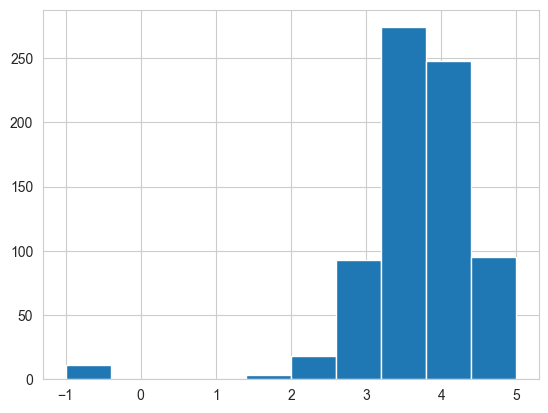

In [309]:
df['Rating'].hist()

<Axes: >

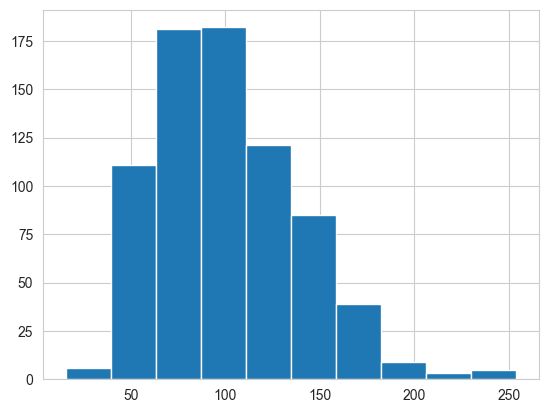

In [310]:
df['average_salary'].hist()

<Axes: >

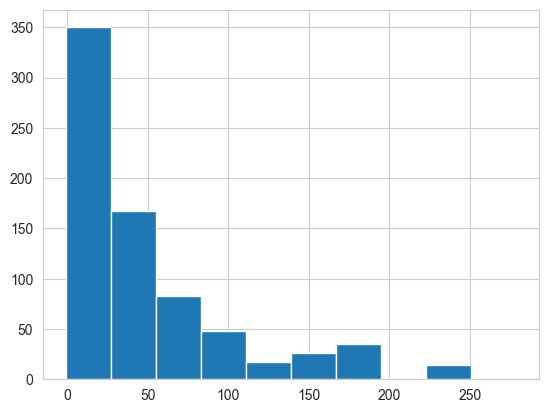

In [311]:
df['age'].hist()

<Axes: >

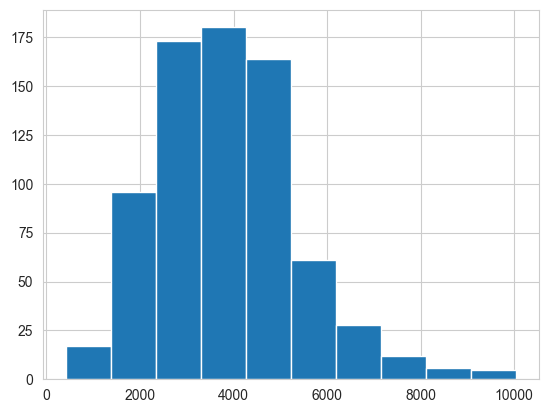

In [312]:
df['desc_len'].hist()

<Axes: xlabel='average_salary'>

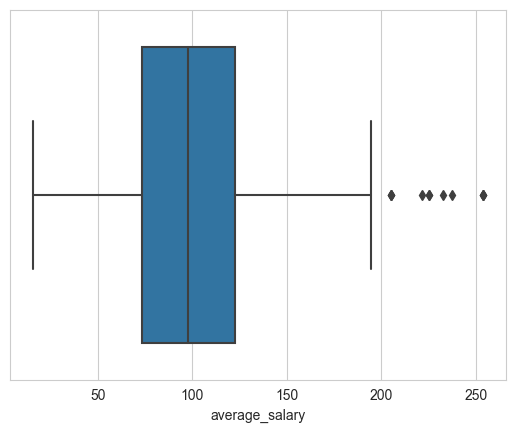

In [313]:
sns.boxplot(data=df, x='average_salary')

<Axes: xlabel='Rating'>

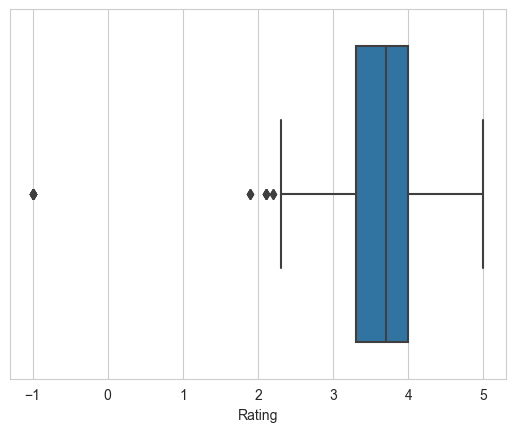

In [314]:
sns.boxplot(data=df, x='Rating')

<Axes: xlabel='age'>

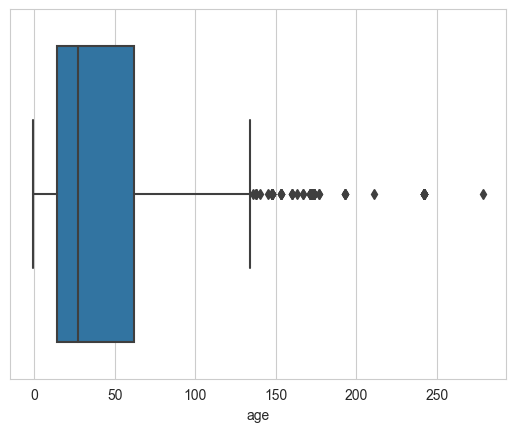

In [315]:
sns.boxplot(data=df, x='age')

<Axes: xlabel='desc_len'>

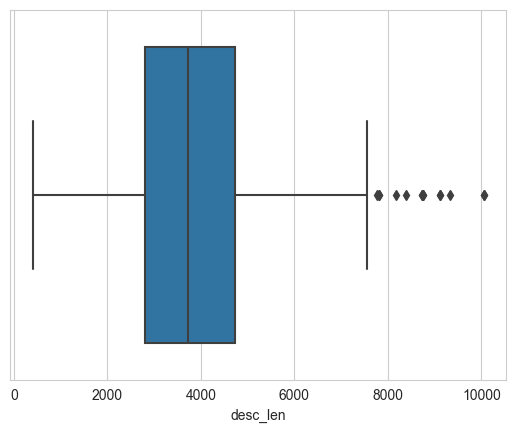

In [316]:
sns.boxplot(data=df, x='desc_len')

In [317]:
correlation = df[['age', 'average_salary', 'Rating', 'desc_len', 'num_com']].corr()

<Axes: >

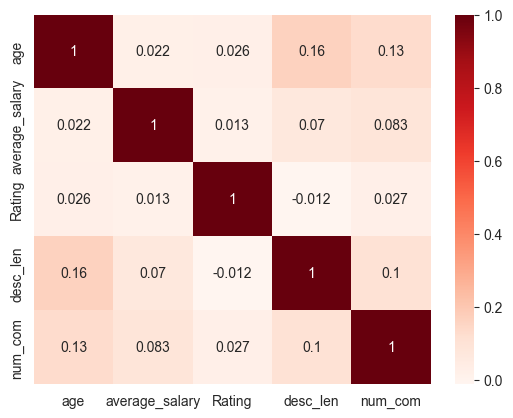

In [318]:
sns.heatmap(correlation, annot=True, cmap='Reds')

In [319]:
df_cat = df.select_dtypes('object')
df_cat

,Job Title,Salary Estimate,Job Description,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,Competitors,company_txt,job_state,job_simp,seniority
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,Tecolote Research,NM,data scientist,na
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,University of Maryland Medical System,MD,data scientist,na
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,KnowBe4,FL,data scientist,na
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",PNNL,WA,data scientist,na
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",Affinity Solutions,NY,data scientist,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,"Sr Scientist, Immuno-Oncology - Oncology",$58K-$111K (Glassdoor est.),Site Name: USA - Massachusetts - Cambridge\nPo...,GSK\n3.9,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),"Pfizer, AstraZeneca, Merck",GSK,MA,na,senior
738,Senior Data Engineer,$72K-$133K (Glassdoor est.),THE CHALLENGE\nEventbrite has a world-class da...,Eventbrite\n4.4,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"See Tickets, TicketWeb, Vendini",Eventbrite,TN,data engineer,senior
739,"Project Scientist - Auton Lab, Robotics Institute",$56K-$91K (Glassdoor est.),The Auton Lab at Carnegie Mellon University is...,Software Engineering Institute\n2.6,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,College / University,Colleges & Universities,Education,Unknown / Non-Applicable,-1,Software Engineering Institute,PA,na,na
740,Data Science Manager,$95K-$160K (Glassdoor est.),Data Science ManagerResponsibilities:\n\nOvers...,"Numeric, LLC\n3.2","Allentown, PA","Chadds Ford, PA",1 to 50 employees,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1,"Numeric, LLC",PA,manager,na


<Axes: xlabel='Job Title', ylabel='count'>

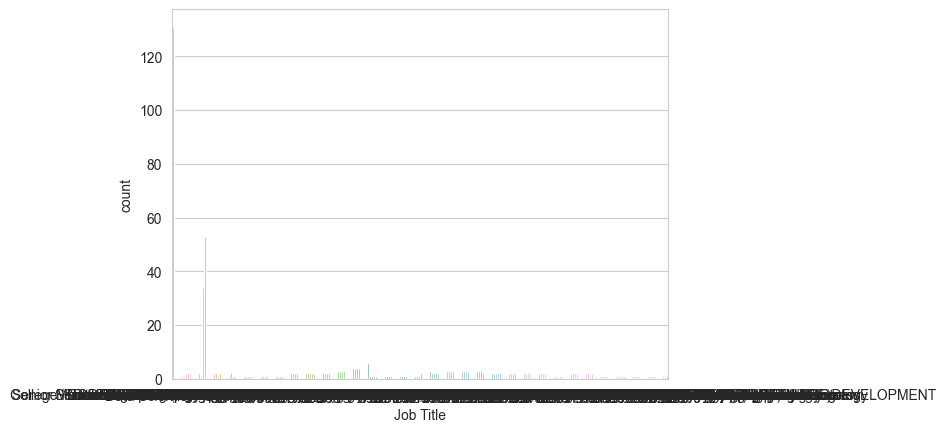

In [320]:
sns.countplot(data=df_cat, x='Job Title')

<Axes: xlabel='Location', ylabel='count'>

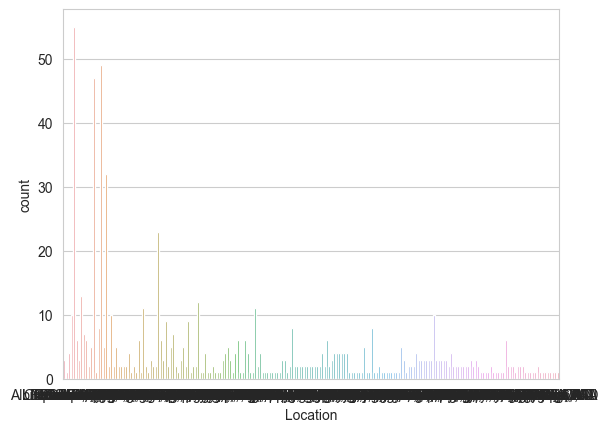

In [321]:
sns.countplot(data=df_cat, x='Location')

In [322]:
df.groupby(['job_simp', 'seniority'])['average_salary'].mean()

job_simp        seniority
analyst         jr            56.500000
                na            61.155405
                senior        80.092593
data engineer   na            96.701220
                senior       124.689189
data scientist  jr           106.500000
                na           107.043011
                senior       138.956522
director        na           168.607143
manager         na            84.022727
mle             na           119.133333
                senior       142.071429
na              na            78.500000
                senior       109.061404
Name: average_salary, dtype: float64

In [323]:
pd.pivot_table(df, index=['job_state', 'job_simp'], values='average_salary', aggfunc='count').sort_values('job_state', ascending=False)
#df.groupby('job_state')['average_salary'].mean()

average_salary
job_state job_simp                      
WI        na                           4
          data scientist               3
          analyst                      3
WA        na                           1
          data scientist              17
...                                  ...
AZ        analyst                      1
          na                           2
AL        na                           2
          data engineer                1
          analyst                      5

[114 rows x 1 columns]

In [324]:
pd.pivot_table(df[df['job_simp'] == 'data scientist'], index='job_state', values='average_salary', aggfunc='mean').sort_values('average_salary', ascending=False)

,average_salary
job_state,
DC,149.000000
CA,142.522059
UT,140.500000
MO,127.666667
IL,117.233333
NC,117.000000
NY,115.250000
MA,113.750000
WI,113.500000


In [325]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary',
       'average_salary', 'company_txt', 'job_state', 'same_state', 'age',
       'python_yn', 'R_yn', 'spark_yn', 'aws_yn', 'excel_yn', 'job_simp',
       'seniority', 'desc_len', 'num_com'],
      dtype='object')

In [326]:
df_pivots = df[['Rating', 'Industry', 'Sector', 'Revenue', 'num_com', 'hourly', 'employer_provided', 'python_yn', 'R_yn', 'spark_yn', 'aws_yn', 'excel_yn', 'Type of ownership','average_salary']]
df_pivots

,Rating,Industry,Sector,Revenue,num_com,hourly,employer_provided,python_yn,R_yn,spark_yn,aws_yn,excel_yn,Type of ownership,average_salary
0,3.8,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,0,1,0,0,0,1,Company - Private,72.0
1,3.4,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),0,0,0,1,0,0,0,0,Other Organization,87.5
2,4.8,Security Services,Business Services,$100 to $500 million (USD),0,0,0,1,0,1,0,1,Company - Private,85.0
3,3.8,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),3,0,0,1,0,0,0,0,Government,76.5
4,2.9,Advertising & Marketing,Business Services,Unknown / Non-Applicable,3,0,0,1,0,0,0,1,Company - Private,114.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,3.9,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),3,0,0,0,0,0,1,0,Company - Public,84.5
738,4.4,Internet,Information Technology,$100 to $500 million (USD),3,0,0,1,0,1,1,0,Company - Public,102.5
739,2.6,Colleges & Universities,Education,Unknown / Non-Applicable,0,0,0,0,0,0,0,1,College / University,73.5
740,3.2,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),0,0,0,0,0,0,0,1,Company - Private,127.5


In [327]:
for i in df_pivots.columns[:-1]:
    print(i)
    print(pd.pivot_table(df_pivots, index=i, values='average_salary').sort_values('average_salary', ascending=False))

Rating
        average_salary
Rating                
-1.0        136.181818
 5.0        134.700000
 2.5        120.000000
 4.5        117.714286
 4.1        116.368421
 3.9        113.071429
 2.6        109.083333
 4.4        108.606061
 4.0        107.170213
 3.2        106.928571
 3.7        105.680328
 3.5        104.897959
 4.7        103.983871
 3.3        103.897436
 4.3        102.468750
 4.2        100.442308
 2.2         97.750000
 3.8         97.418033
 4.6         97.250000
 2.1         95.900000
 3.4         93.465909
 3.6         89.945652
 1.9         87.500000
 3.1         86.580000
 3.0         85.588235
 2.7         85.178571
 2.8         83.928571
 2.3         81.500000
 2.9         81.138889
 4.8         80.277778
 2.4         60.214286
Industry
                                          average_salary
Industry                                                
Other Retail Stores                           163.500000
Motion Picture Production & Distribution      146.0000

In [328]:
pd.pivot_table(df_pivots, index = 'Revenue', columns = 'python_yn', values = 'average_salary', aggfunc = 'count')

python_yn,0,1
Revenue,,
$1 to $2 billion (USD),16.0,44.0
$1 to $5 million (USD),1.0,7.0
$10 to $25 million (USD),16.0,16.0
$10+ billion (USD),66.0,58.0
$100 to $500 million (USD),47.0,44.0
$2 to $5 billion (USD),17.0,22.0
$25 to $50 million (USD),24.0,16.0
$5 to $10 billion (USD),9.0,10.0
$5 to $10 million (USD),9.0,9.0


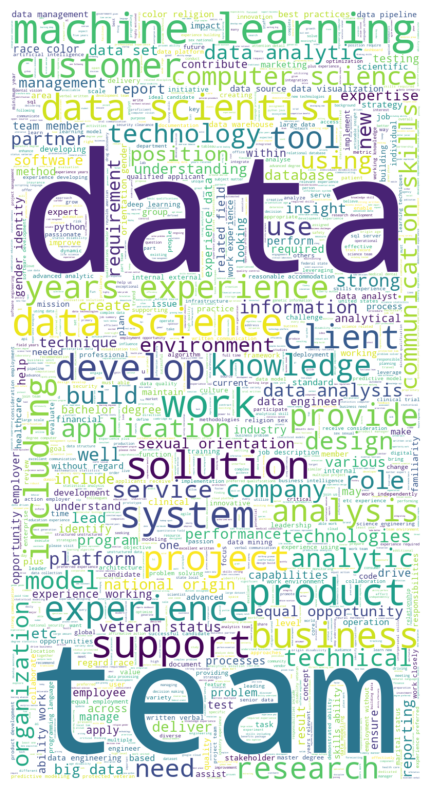

In [329]:
words = " ".join(df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

Building the model

In [330]:
df_model = df[['average_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_com','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark_yn','aws_yn','excel_yn','job_simp','seniority','desc_len']]

In [331]:
df_dum = pd.get_dummies(df_model)

In [332]:
df_dum

,average_salary,Rating,num_com,hourly,employer_provided,same_state,age,python_yn,spark_yn,aws_yn,...,job_simp_analyst,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_manager,job_simp_mle,job_simp_na,seniority_jr,seniority_na,seniority_senior
0,72.0,3.8,0,0,0,0,50,1,0,0,...,False,False,True,False,False,False,False,False,True,False
1,87.5,3.4,0,0,0,0,39,1,0,0,...,False,False,True,False,False,False,False,False,True,False
2,85.0,4.8,0,0,0,1,13,1,1,0,...,False,False,True,False,False,False,False,False,True,False
3,76.5,3.8,3,0,0,1,58,1,0,0,...,False,False,True,False,False,False,False,False,True,False
4,114.5,2.9,3,0,0,1,25,1,0,0,...,False,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,84.5,3.9,3,0,0,0,193,0,0,1,...,False,False,False,False,False,False,True,False,False,True
738,102.5,4.4,3,0,0,0,17,1,1,1,...,False,True,False,False,False,False,False,False,False,True
739,73.5,2.6,0,0,0,1,39,0,0,0,...,False,False,False,False,False,False,True,False,True,False
740,127.5,3.2,0,0,0,0,-1,0,0,0,...,False,False,False,False,True,False,False,False,True,False


Labels, Features

In [333]:
X = df_dum.drop('average_salary', axis =1)
y = df_dum['average_salary'].values

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression Model

In [335]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [336]:
np.mean(cross_val_score(lm, X_train, y_train, cv=3, scoring='neg_mean_absolute_error'))

-20.76600241167036

Lasso Model

In [337]:
lm_l = Lasso()
np.mean(cross_val_score(lm_l, X_train, y_train, cv=3, scoring='neg_mean_absolute_error'))

-21.023500960774395

,alpha,error
13,0.14,-19.359152


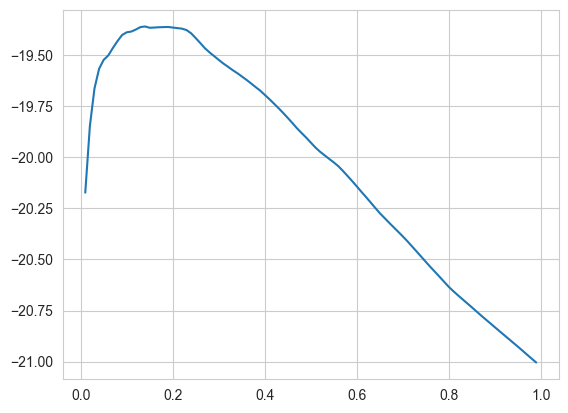

In [338]:
alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

In [339]:
lm_l = Lasso(alpha=.14)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

-19.359152052688227

Random Forest Regressor Model

In [340]:
rf = RandomForestRegressor()
np.mean(cross_val_score(rf, X_train, y_train, cv=3, scoring='neg_mean_absolute_error'))

-15.112226110512912

Grid Search Cross Validation

In [341]:
parameters = {'n_estimators':range(10,300,10), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
87 fits failed out of a total of 261.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
87 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 10)},
             scoring='neg_mean_absolute_error')

In [342]:
gs.best_score_

-15.010112653608848

In [343]:
gs.best_estimator_

RandomForestRegressor(max_features='sqrt', n_estimators=120)

In [344]:
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

In [345]:
mean_absolute_error(y_test,tpred_lm)

645517905.8755273

In [346]:
mean_absolute_error(y_test,tpred_lml)

19.741551501382403

In [347]:
mean_absolute_error(y_test,tpred_rf)

12.183892617449663

Saving the model

In [348]:
pickl = {
    'model' : gs.best_estimator_
}
pickle.dump(pickl, open('model_file' + '.p', 'wb'))

In [349]:
file_name = 'model_file.p'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [350]:
model

RandomForestRegressor(max_features='sqrt', n_estimators=120)